In [103]:
! pip -q install transformers

In [104]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
model_size = "small"
tokenizer = AutoTokenizer.from_pretrained(f"microsoft/DialoGPT-{model_size}")
model = AutoModelForCausalLM.from_pretrained(f"microsoft/DialoGPT-{model_size}")

In [105]:
import numpy as np
import pandas as pd
import json
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [106]:
from google.colab import drive
drive.mount('/content/drive')
input_file_path = '/content/drive/My Drive/NLP Datasets/train-v1.1.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
def squad_json_to_dataframe(input_file_path, record_path = ['data','paragraphs','qas','answers'], verbose = 1):
    if verbose:
        print("Reading the json file")
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])

    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [108]:
record_path = ['data','paragraphs','qas','answers']
train = squad_json_to_dataframe(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...


<ipython-input-107-32aeff98681f>:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  js = pd.io.json.json_normalize(file , record_path )
<ipython-input-107-32aeff98681f>:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  m = pd.io.json.json_normalize(file, record_path[:-1] )
<ipython-input-107-32aeff98681f>:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  r = pd.io.json.json_normalize(file,record_path[:-2])


shape of the dataframe is (87599, 6)
Done


<ipython-input-107-32aeff98681f>:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()


In [109]:
train.head()

,index,question,context,answer_start,text,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0


In [110]:
train = train.dropna()
df=train

In [111]:
len(df)

87599

In [112]:
df=pd.DataFrame(df.iloc[:1000,:])
df_new=df.astype(str)

In [113]:
df_new, df_val = train_test_split(df_new, test_size = 0.2)
print(len(df_new), len(df_val))
df_new.head()

800 200


,index,question,context,answer_start,text,c_id
29,5733ac31d058e614000b5ff3,What institute at Notre Dame studies the reas...,The Joan B. Kroc Institute for International P...,4,Joan B. Kroc Institute for International Peace...,6
535,56d4c4e72ccc5a1400d8321a,Where was Blue Ivy born?,"On January 7, 2012, Beyoncé gave birth to her ...",91,Lenox Hill Hospital in New York.,75
695,56beb5b23aeaaa14008c9284,"Besides R&B, which genres does Beyonce dabble in?","Beyoncé's music is generally R&B, but she also...",60,"pop, soul and funk",90
557,56bfa3cca10cfb14005511f1,What song did Beyonce record for the film Epic?,Beyoncé embarked on The Mrs. Carter Show World...,560,Rise Up,77
836,56d4e8472ccc5a1400d83320,What clothing line of Beyoncé drew PETA critic...,"In 2006, the animal rights organization People...",158,House of Deréon.,103


In [114]:
class Args():
    def __init__(self):
        self.output_dir = '/content/drive/My Drive/NLP Datasets/output'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [115]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

def load_and_cache_examples(args, tokenizer, df_trn):
    return ConversationDataset(tokenizer, args, df_trn)

def load_and_cache_examples_eval(args, tokenizer, df_val):
    return ConversationDataset(tokenizer, args, df_val)

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)
        directory = args.cache_dir
        cached_features_file = os.path.join(directory, args.model_type + "_cached_lm_" + str(block_size))

        logger.info("Creating features from dataset file at %s", directory)
        self.examples = []
        for _, row in df.iterrows():
            conv = construct_conv(row, tokenizer)
            self.examples.append(conv)

        logger.info("Saving features into cached file %s", cached_features_file)
        with open(cached_features_file, "wb") as handle:
            pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [116]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    logger.info("*** Running trainng, Num examples = %d, Num Epochs = %d ***", len(train_dataset), args.num_train_epochs)

    global_step, epochs_trained = 0, 0
    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

    tb_writer.close()

    return global_step, tr_loss / global_step

In [117]:
def main(df_trn, df_val):
    args = Args()

    # Setup CUDA, GPU & distributed training
    #torch.cuda.is_available = lambda : False
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning("Process rank: %s, device: %s, n_gpu: %s", args.local_rank, device, args.n_gpu)

    set_seed(args) # Set seed

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelForCausalLM.from_pretrained(args.model_name_or_path, from_tf=False, config=config, cache_dir=args.cache_dir)
    model.to(args.device)

    # Training
    train_dataset = load_and_cache_examples(args, tokenizer, df_trn)
    global_step, tr_loss = train(args, train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    os.makedirs(args.output_dir, exist_ok=True)

    logger.info("Saving model checkpoint to %s", args.output_dir)
    model_to_save = (model.module if hasattr(model, "module") else model)  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args.output_dir)
    tokenizer.save_pretrained(args.output_dir)

    # Good practice: save your training arguments together with the trained model
    torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

    # Load a trained model and vocabulary that you have fine-tuned
    model = AutoModelForCausalLM.from_pretrained(args.output_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
    model.to(args.device)

#--- New code entered here
     # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [22]:
#df=pd.DataFrame(df.iloc[:10000,:])

In [118]:
def chat(model, tokenizer, trained=False):
    print("type \"q\" to quit. Automatically quits after 5 messages")

    for step in range(5):
        message = input("MESSAGE: ")

        if message in ["", "q"]:  # if the user doesn't wanna talk
            break

        # encode the new user input, add the eos_token and return a tensor in Pytorch
        new_user_input_ids = tokenizer.encode(message + tokenizer.eos_token, return_tensors='pt')

        # append the new user input tokens to the chat history
        bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids


        # generated a response while limiting the total chat history to 1000 tokens,
        if (trained):
            chat_history_ids = model.generate(
                bot_input_ids,
                max_length=1000,
                pad_token_id=tokenizer.eos_token_id,
                no_repeat_ngram_size=3,
                do_sample=True,
                top_k=100,
                top_p=0.7,
                temperature = 0.8,
            )
        else:
            chat_history_ids = model.generate(
                bot_input_ids,
                max_length=1000,
                pad_token_id=tokenizer.eos_token_id,
                no_repeat_ngram_size=3
            )

        # pretty print last ouput tokens from bot
        print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))


In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
pip uninstall -y mxnet && pip install mxnet-cu75==1.1.0

In [ ]:
!pip install light-the-torch
!ltt install torch torchvision

In [ ]:
!nvcc --version

In [ ]:
!pip install mxnet-cu80

In [18]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [119]:
# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples_eval(args, tokenizer, df_val)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [120]:
config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
model = AutoModelForCausalLM.from_pretrained(args.model_name_or_path, from_tf=False, config=config, cache_dir=args.cache_dir)
train_dataset = load_and_cache_examples(args, tokenizer, df_new)

In [121]:
main(df_new,df_val)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration:   0%|          | 0/200 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.
Using pad_token, but it is not set yet.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1499: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

{'perplexity_': tensor(4.2222)}

In [122]:
chat(model, tokenizer, trained=True)

type "q" to quit. Automatically quits after 5 messages
MESSAGE: hi


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: Hi
MESSAGE: Which city has beautiful beaches in US


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: And yet it's still a beautiful city
MESSAGE: Is Pittsburgh a small town ?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: A city of 200,000 people with a population of 1.3 million.
MESSAGE: Which river flow in Pittsburgh city


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: And the river is named after the river in question, which flows in the same way that the river flows in Chicago.
MESSAGE: how far is pittsburgh from chicago


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: It's a river


## End here

In [96]:
#tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
#model = AutoModelWithLMHead.from_pretrained(args.output_dir)


In [ ]:

chat(model, tokenizer, trained=True)

In [36]:
from collections import Counter
from statistics import mean, median, stdev
import numpy as np
import matplotlib.pyplot as plt

In [37]:
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]

    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

In [38]:
trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1)

9356     573366a64776f41900660a00 What is Île Frégate i...
19078    56f89bea9e9bad19000a01bd What kind of climate ...
18733    56f71f1c3d8e2e1400e37371 What does Procopius d...
34230    570f38055ab6b81900390ea4 How long a rhythm wer...
82801    57312a93e6313a140071ccaf What populations is t...
                               ...                        
54765    57271b17708984140094d9d9 What prime factor did...
63071    572869712ca10214002da319 How much did Matrox's...
73153    57304f5e2461fd1900a9cd11 How did the Bristol B...
74275    573127a7497a881900248bdf What country had the ...
11784    56df73c156340a1900b29b9a Who broke the world r...
Length: 70079, dtype: object

In [39]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
lens, tok_cnt, word_cnt = get_counter_and_lens(trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (25742 > 1024). Running this sequence through the model will result in indexing errors


In [40]:
def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

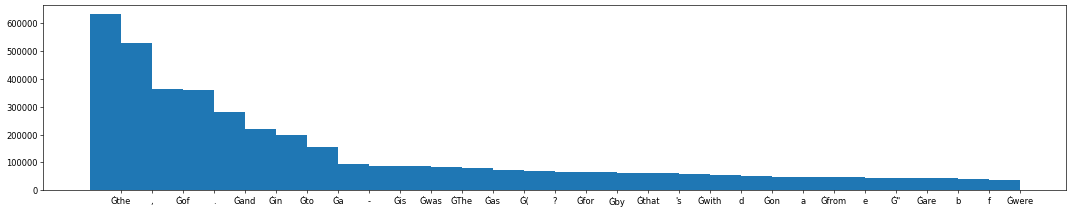

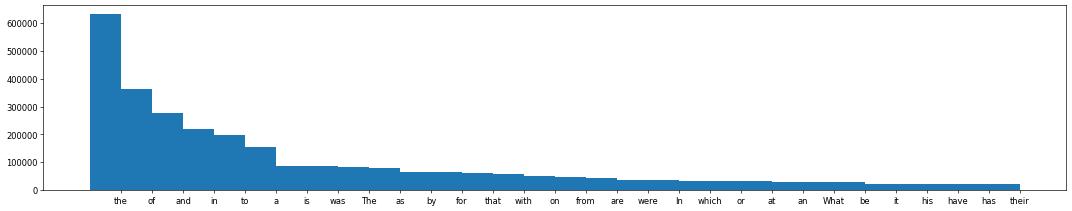

In [41]:
plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

In [42]:
def plot_hist(lens, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Mean: 190.2027283494342, Median: 177, Standard Deviation: 117.0138008301787, 90th Percentile: 25742.0


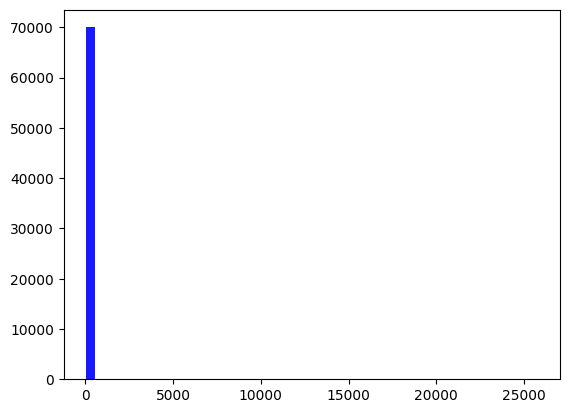

In [43]:
print(f'Mean: {mean(lens)}, Median: {median(lens)}, Standard Deviation: {stdev(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plot_hist(lens)